<a href="https://colab.research.google.com/github/Manas-P/forecasting_co2_emission_threshold/blob/main/Forecast_co2_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
url='https://raw.githubusercontent.com/Manas-P/forecasting_co2_emission_threshold/main/emission_dataset.csv'
df=pd.read_csv(url)

In [4]:
df.head()

,Date,Amount
0,2010-01,126
1,2010-02,124
2,2010-03,125
3,2010-04,126
4,2010-05,124


In [5]:
df.tail()

,Date,Amount
127,2020-08,213
128,2020-09,218
129,2020-10,217
130,2020-11,220
131,2020-12,219


In [6]:
df.columns=["Month","CO2 Amount (g/mile)"] #Change Title
df.head()

,Month,CO2 Amount (g/mile)
0,2010-01,126
1,2010-02,124
2,2010-03,125
3,2010-04,126
4,2010-05,124


In [7]:
df['Month']=pd.to_datetime(df['Month']) #Converted Month into Datetime

In [9]:
df.head()

,Month,CO2 Amount (g/mile)
0,2010-01-01,126
1,2010-02-01,124
2,2010-03-01,125
3,2010-04-01,126
4,2010-05-01,124


In [10]:
df.set_index('Month',inplace=True) #Set month column as index

In [11]:
df.head()

,CO2 Amount (g/mile)
Month,
2010-01-01,126
2010-02-01,124
2010-03-01,125
2010-04-01,126
2010-05-01,124


In [12]:
df.describe()

,CO2 Amount (g/mile)
count,132.000000
mean,178.606061
std,27.363194
min,124.000000
25%,163.000000
50%,188.500000
75%,198.250000
max,220.000000


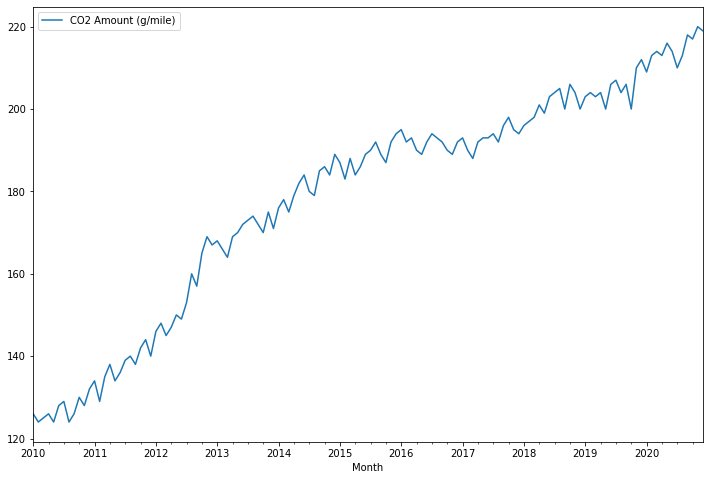

In [14]:
df.plot(figsize=(12,8))

In [16]:
from statsmodels.tsa.arima_model import ARIMA

In [20]:
model=ARIMA(df['CO2 Amount (g/mile)'],order=(1,1,1))
model_fit=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [21]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARIMA Model Results                               
=================================================================================
Dep. Variable:     D.CO2 Amount (g/mile)   No. Observations:                  131
Model:                    ARIMA(1, 1, 1)   Log Likelihood                -323.549
Method:                          css-mle   S.D. of innovations              2.857
Date:                   Tue, 14 Dec 2021   AIC                            655.098
Time:                           21:19:04   BIC                            666.599
Sample:                       02-01-2010   HQIC                           659.771
                            - 12-01-2020                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.7219      0.125      5.779      0.000       0.477       0.967
ar.L1.D.CO2 Amount (g/mile)     0.0751      0.145      0.519      0.605      -0.209       0.359
ma.L1.D.CO2 Amount (g/mile)    -0.5411      0.112     -4.839      0.000      -0.760      -0.322
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           13.3096           +0.0000j           13.3096            0.0000
MA.1            1.8479           +0.0000j            1.8479            0.0000
-----------------------------------------------------------------------------
"""

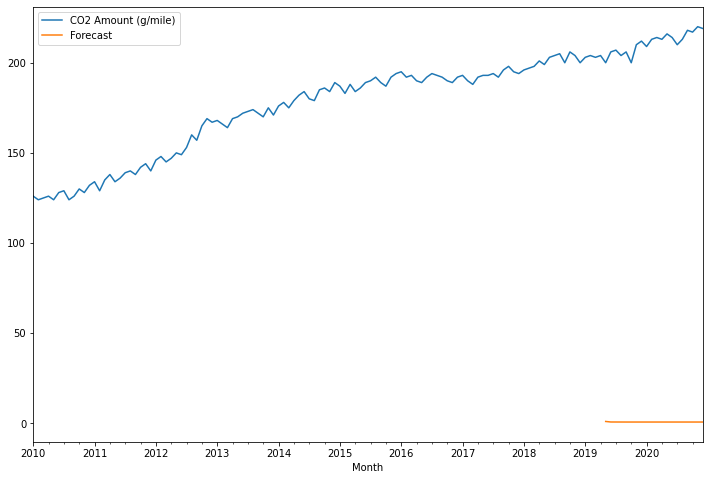

In [22]:
df['Forecast']=model_fit.predict(start=112,end=131,dynamic=True)
df[['CO2 Amount (g/mile)','Forecast']].plot(figsize=(12,8))

In [23]:
import statsmodels.api as sm

In [24]:
model=sm.tsa.statespace.SARIMAX(df['CO2 Amount (g/mile)'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


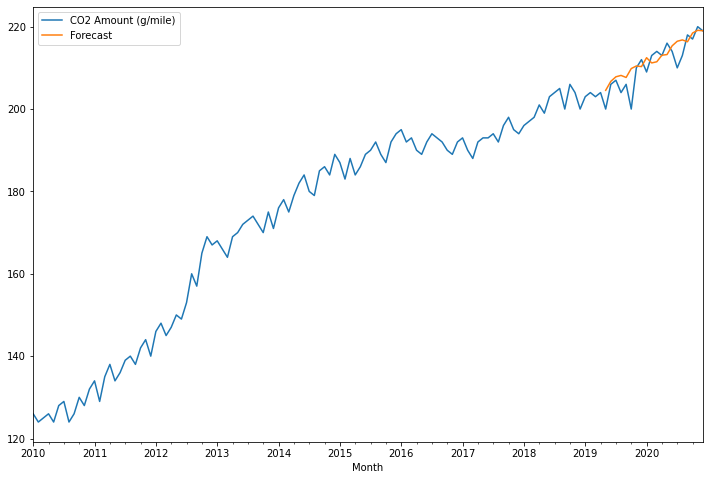

In [26]:
df['Forecast']=results.predict(start=112,end=131,dynamic=True)
df[['CO2 Amount (g/mile)','Forecast']].plot(figsize=(12,8))

In [27]:
#To find future
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,96)] #Given upto 8 years

In [28]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns) #Future values

In [29]:
future_datest_df.tail()

,CO2 Amount (g/mile),Forecast
2028-07-01,NaN,NaN
2028-08-01,NaN,NaN
2028-09-01,NaN,NaN
2028-10-01,NaN,NaN
2028-11-01,NaN,NaN


In [30]:
future_df=pd.concat([df,future_datest_df]) #Concatenate current dataset to future dataset

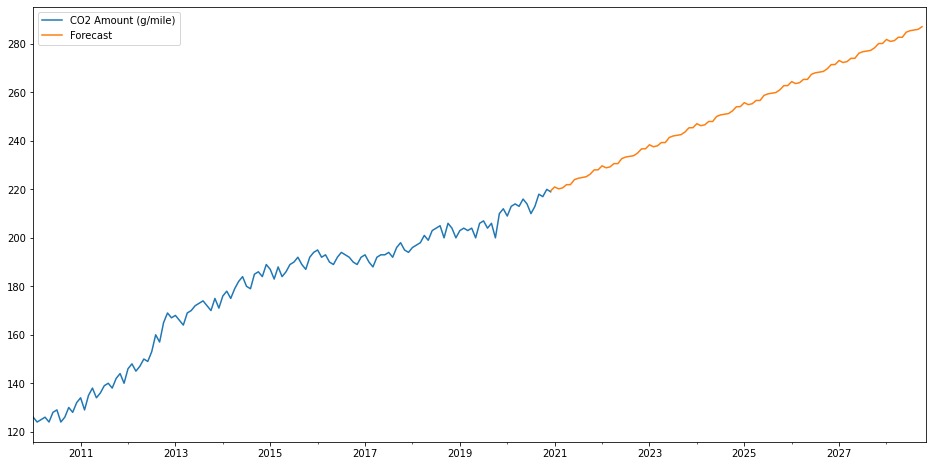

In [40]:
future_df['Forecast'] = results.predict(start = 131, end = 225, dynamic= True)   
future_df[['CO2 Amount (g/mile)', 'Forecast']].plot(figsize=(16, 8)) 

In [42]:
#Predicting the year when the co2 emission will exceed the limit
df_new = future_df[future_df['Forecast'] >= 250].index[0]
print("Your vehicle will emit harmfull gas at the ear of: ",df_new)

Your vehicle will emit harmfull gas at the ear of:  2024-06-01 00:00:00
